In [1]:
%matplotlib inline
from collections import defaultdict
import sys

import numpy as np
import tables
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
fname = '../raw/total-3L.h5'

In [3]:
#store = pd.HDFStore(fname, 'r')
store = tables.open_file(fname, 'r')

In [4]:
for n in store.get_node('/'):  # .root
    print(n)
for n in store.get_node('/3L'): # .3L
    print(n)

/3L (Group) ''
/3L/calldata (Group) ''
/3L/samples (Array(765,)) ''
/3L/variants (Group) ''


In [5]:
samples = store.get_node('/3L/samples').read()
print(type(samples))
print(samples[:10])

<class 'numpy.ndarray'>
[b'AB0085-C' b'AB0087-C' b'AB0088-C' b'AB0089-C' b'AB0090-C' b'AB0091-C'
 b'AB0092-C' b'AB0094-C' b'AB0095-C' b'AB0097-C']


In [6]:
call_data = store.get_node('/3L').calldata
samples = store.get_node('/3L/samples')
variants = store.get_node('/3L/variants')
variants.POS[-1]

41956556

In [7]:
samples[:10]

array([b'AB0085-C', b'AB0087-C', b'AB0088-C', b'AB0089-C', b'AB0090-C',
       b'AB0091-C', b'AB0092-C', b'AB0094-C', b'AB0095-C', b'AB0097-C'], 
      dtype='|S8')

In [8]:
# store['/3L/variants/ANN']  # no no no!

In [9]:
# no no no
#for rec in store['/3L/variants/ANN']:
#    print(rec)
#    break

## Size of objects

In [10]:
annotations_np = variants.ANN.read()  # load time

In [11]:
print(type(annotations_np))
annotations_np[0]

<class 'numpy.ndarray'>


(b'T', b'intergenic_region', b'MODIFIER', b'AGAP010310', b'AGAP010310', b'intergenic_region', b'AGAP010310', b'.', -1, b'.', b'.', -1, -1, -1, -1, -1, -1, -1)

In [12]:
ann = store.get_node('/3L/variants/ANN')
print(type(ann))
for i, rec in enumerate(ann):
    print(rec.nrow)
    print(rec.fetch_all_fields())
    if i == 1:
        break

<class 'tables.table.Table'>
0
(b'T', b'intergenic_region', b'MODIFIER', b'AGAP010310', b'AGAP010310', b'intergenic_region', b'AGAP010310', b'.', -1, b'.', b'.', -1, -1, -1, -1, -1, -1, -1)
1
(b'A', b'intergenic_region', b'MODIFIER', b'AGAP010310', b'AGAP010310', b'intergenic_region', b'AGAP010310', b'.', -1, b'.', b'.', -1, -1, -1, -1, -1, -1, -1)


In [13]:
#This is not very honest and a complex problem...
print(sys.getsizeof(annotations_np))
print(sys.getsizeof(ann))
print(ann.size_in_memory)
print(ann.size_on_disk)

1841849959
112
1841849863
47705417


# Exploration

## Number of markers

#number of bi-allelic SNPs with all call data and

In [14]:
accessibility_array = store.get_node('/3L/variants/Accessible')
accessibility_array.shape

(9643193,)

In [15]:
is_snp_array = store.get_node('/3L/variants/is_snp')
print(is_snp_array.shape)
is_snp = is_snp_array.read()
print(sum(is_snp))
del is_snp

(9643193,)
9643193


In [16]:
alt_alleles = store.get_node('/3L/variants/AC')
total_alleles = store.get_node('/3L/variants/AN')

In [17]:
print(total_alleles.size_on_disk)
print(total_alleles.size_in_memory)

365952
19286386


In [18]:
print(alt_alleles.shape)
print(total_alleles.shape)

(9643193, 3)
(9643193,)


In [19]:
total_alleles_read = total_alleles.read()
total_alleles_read.sort()

In [20]:
num_alts = [len(list(filter(lambda x: x>0, alts))) for alts in alt_alleles.iterrows()]

In [21]:
num_alts_count = [0, 0, 0]
for num in num_alts:
    num_alts_count[num - 1] += 1

In [22]:
num_alts_count

[7449486, 1998477, 195230]

([<matplotlib.patches.Wedge at 0x7fb3767acd30>,
  <matplotlib.text.Text at 0x7fb37676bef0>])

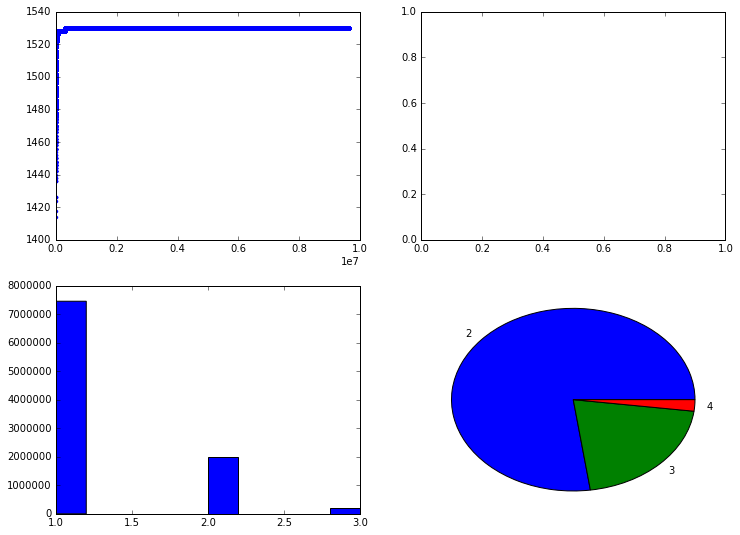

In [ ]:
fig, ax = plt.subplots(2, 2, squeeze=False, figsize=(12,9))
ax[0, 0].plot(total_alleles_read, '.')
ax[1, 0].hist(num_alts)
ax[1, 1].pie(num_alts_count, labels=range(2, 5))

# singletons et al (for bi-allelic snps)

In [ ]:
poses = store.get_node('/3L/variants/POS')
is_called = store.get_node('/3L/calldata/is_called')
genotype = store.get_node('/3L/calldata/genotype')
maf_count = defaultdict(int)
for i, snp_pos, snp_called, snp_genotype, snp_alts in zip(range(len(is_called)), poses, is_called, genotype, num_alts):
    if snp_alts > 1:
        continue
    counts = [0, 0, 0]
    for sample_called, sample_genotype in zip(snp_called, snp_genotype):
        if sample_called == 0:
            continue
        if max(sample_genotype) > 1:
            print(i, snp_alts, sample_genotype)
        counts[sample_genotype[0]] += 1
        counts[sample_genotype[1]] += 1
    maf_count[min(counts)] += 1
    if i % 1000 == 0:
        print(maf_count)

defaultdict(<class 'int'>, {0: 1})
defaultdict(<class 'int'>, {0: 963})
defaultdict(<class 'int'>, {0: 1927})
defaultdict(<class 'int'>, {0: 2893})


# store

In [ ]:
store